## Part 2: Nearest-neighbor image classification
<a id=part2></a>

In this part, we'll familiarize ourselves with the `PyTorch` tensor API by implementing a very simple classifier,
kNN, using tensor operations alone.
We'll then implement cross-validation, an important ML technique used to find a suitable
set values for a model's hyperparameters.

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import unittest

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12})
torch.random.manual_seed(1904)
test = unittest.TestCase()

### kNN Classification
<a id=part2_1></a>

Arguably the most basic classification scheme in a supervised learning setting is the
`k` nearest-neighbor (kNN) classifier.
Given a training data set, kNN's "training" phase consists of simply memorizing it.
When a classification of an unseen sample is required, it's distance (usually L1 or L2)
is computed from all training samples.
The unseen sample is then classified according to the majority label of it's `k` nearest-neighbors.

Here we'll implement the most basic kNN, working directly on image pixel values and computing L2 distance
between a test image and every known training image.
We'll use data from the [MNIST](http://yann.lecun.com/exdb/mnist/) database of handwritten digits.
This database contains single-channel images with a constant black background and the digits are
roughly the same size, which makes it feasible to obtain bearable classification accuracy even with
such a naïve model.

Note however that real-world KNN model are often implemented with tree-based data structures to
find nearest neighbors in logarithmic time, specialized distance functions and
using image features instead of raw pixels.

**TODO** Implement the `TensorView` transform in the `hw1/transforms` module, and run the following code to
load the data we'll work with.

In [2]:
# Prepare data for kNN Classifier
import torchvision.transforms as tvtf
import helpers.dataloader_utils as dataloader_utils
import hw1.datasets as hw1datasets
import hw1.transforms as hw1tf

# Define the transforms that should be applied to each CIFAR-10 image before returning it
tf_ds = tvtf.Compose([
    tvtf.ToTensor(), # Convert PIL image to pytorch Tensor
    hw1tf.TensorView(-1), # Reshape to 1D Tensor
])

# Define how much data to load (only use a subset for speed)
num_train = 10000
num_test = 1000
batch_size = 1024

# Training dataset & loader
ds_train = hw1datasets.SubsetDataset(
    torchvision.datasets.MNIST(root='./data/mnist/', download=True, train=True, transform=tf_ds), num_train)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size)

# Test dataset & loader
ds_test = hw1datasets.SubsetDataset(
    torchvision.datasets.MNIST(root='./data/mnist/', download=True, train=False, transform=tf_ds), num_test)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size)


**TODO** Complete the implementation of the kNN classifier in the module `hw1/knn_classifier.py`:
1. Implement L2 distance calculation in `calc_distances()`.
1. Implement label prediction in `predict()`.
1. Implement accuracy calculation in the `accuracy()` function.

Use the following code to test your implementation.

In [3]:
import hw1.knn_classifier as hw1knn

# Get all test data to predict in one go
x_test, y_test = dataloader_utils.flatten(dl_test)

# Test kNN Classifier
knn_classifier = hw1knn.KNNClassifier(k=10)
knn_classifier.train(dl_train)
y_pred = knn_classifier.predict(x_test)

# Calculate accuracy
accuracy = hw1knn.accuracy(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

# Sanity check
test.assertGreater(accuracy, 0.8)

Accuracy: 91.50%


### Cross-validation
<a id=part2_2></a>

A common way to  choose hyperparameters for a model or even the model itself is by applying
**K-fold cross-validation**.
For each candidate set of hyperparameters, the model is trained `K` times, each time with a different split of the training data to train and validation sets (called a fold). The set of hyperparameters which resulted in the the lowest average validation error rate is selected.

More specifically:

1. For all choices of a model and/or set of hyperparameters for the model:
    1. Split training set into `K` non-overlapping parts. 
    1. For `k=0,...,K-1`:
        1. Select the `k`-th part as the validation set and the remaining `k-1` parts as the training set.
        1. Train the current model on the current training set.
        1. Evaluate the model on the current validation set to obtain it's validation error.
        1. Update the current model's average validation error.
    1. Select the model with the lowest average validation error.
1. Train the selected model with the entire training set.
1. Evaluate the model with the test set.


Now we would like to find the best value of K for applying our kNN model to CIFAR-10.
In this case we already fixed the model and there is only one hyperparameter, the value of `k`
(not to be confused with `K`, the number of folds for the cross validation).

**TODO** Complete the implementation of the `find_best_k` function in the `knn_classifier.py` module.

In [4]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

# Run cross-validation
best_k, accuracies = hw1knn.find_best_k(ds_train, k_choices, num_folds)

best_k = 3


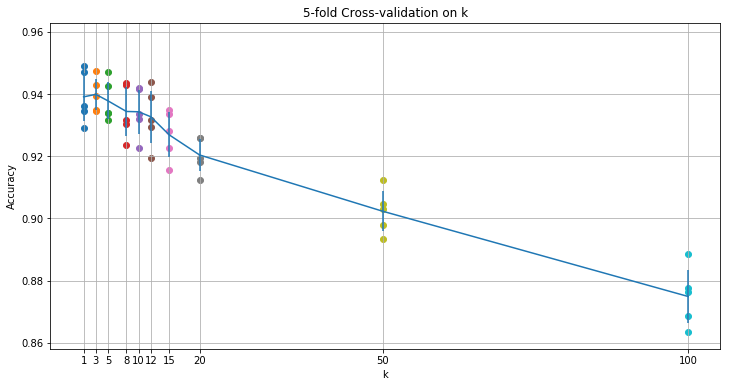

In [5]:
# Plot accuracies per k
_, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(xticks=k_choices))
for i, k in enumerate(k_choices):
    curr_accuracies = accuracies[i]
    ax.scatter([k] * len(curr_accuracies), curr_accuracies)

accuracies_mean = np.array([np.mean(accs) for accs in accuracies])
accuracies_std = np.array([np.std(accs) for accs in accuracies])
ax.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
ax.set_title(f'{num_folds}-fold Cross-validation on k')
ax.set_xlabel('k')
ax.set_ylabel('Accuracy')
ax.grid()

print('best_k =', best_k)

Now that we found our `best_k`, we can train the model with that value of `k` on the full training set and evaluate the accuracy on the test set:

In [6]:
knn_classifier = hw1knn.KNNClassifier(k=best_k)
knn_classifier.train(dl_train)
y_pred = knn_classifier.predict(x_test)

# Calculate accuracy
accuracy_best_k = hw1knn.accuracy(y_test, y_pred)
print(f'Accuracy: {accuracy_best_k*100:.2f}%')

test.assertGreater(accuracy_best_k, accuracy)

Accuracy: 91.90%


### Questions

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw1/answers.py`.

In [9]:
from helpers.answers import display_answer
import hw1.answers

#### Question 1

Does increasing `k` lead to improved generalization for unseen data? Why or why not? Up to what point? Think about the extremal values of `k`.

In [15]:
display_answer(hw1.answers.part2_q1)


**Your answer:**



Increasing `k` increases the generalisation until a cerain point, we can see in the graph that after `k = 3` the accuracy starts to decline.
this happens because we let more samples that might be farther apart and of the wrong class. to emphasize this point, let's think of what happens when `k == N` (`N` is size of dataset) in that case we just return the majority label in the dataset.

